In [1]:
# Integration of endo cells using scvi-tools

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scvi

from matplotlib.pyplot import rc_context

Global seed set to 0
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
sc.settings.verbosity = 3
sc.set_figure_params(dpi=80, frameon=False, color_map='viridis_r', dpi_save=600)
palette_d = ['#378C4F', '#6DB6FFFF', '#F5CDCD', '#D9579B', '#A59ACB', '#7464AA', '#7BBC5E',  '#006DDBFF', '#B6DBFFFF', '#E2A7CC', '#924900FF']

In [8]:
adata_sc = scvi.data.read_h5ad('scRNA_caf.h5ad')

In [9]:
adata_sn = scvi.data.read_h5ad('snRNA_caf.h5ad')

In [5]:
adata = adata_sc.concatenate(adata_sn)

/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [6]:
adata.obs

,patient_id,condition,sampletype,nCount_RNA,nFeature_RNA,mt_ratio,celltype,batch
PNT2_AGCATCATCGGTTCAA-1-0-0,scPNT2,adjancant normal,scRNA-seq,20437.0,4384,4.995400,mCAF,0
PNT2_GTCCTCAGTGGCCACT-1-0-0,scPNT2,adjancant normal,scRNA-seq,16487.0,4638,7.187929,mCAF,0
PNT2_GCCGTGAGTGATTCAC-1-0-0,scPNT2,adjancant normal,scRNA-seq,16823.0,3957,6.569140,vCAF,0
PNT2_GACAGCCGTGGCTGAA-1-0-0,scPNT2,adjancant normal,scRNA-seq,16623.0,4153,3.971711,mCAF,0
PNT2_GGGTAGAGTGGTCCGT-1-0-0,scPNT2,adjancant normal,scRNA-seq,13315.0,3524,6.454644,vCAF,0
...,...,...,...,...,...,...,...,...
RT3_AGCGCCACATCGGAGA-1-1-1,snRT3,tumor,snRNA-seq,2385.0,1469,0.000000,unknown,1
RT3_GTCGCGAGTGACAACG-1-1-1,snRT3,tumor,snRNA-seq,2270.0,1409,0.158541,unknown,1
RT3_ACCTGAAAGAGCTGCA-1-1-1,snRT3,tumor,snRNA-seq,1926.0,1025,0.000000,unknown,1
RT3_GCCAGCAAGCGAGTAC-1-1-1,snRT3,tumor,snRNA-seq,2179.0,1329,0.000000,unknown,1


In [7]:
adata.layers['counts'] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


In [8]:
# select HVGs
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="sampletype",
    subset=True
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [12]:
adata.obs.patient_id.value_counts()

patient_id
snPNT2    932
scPT5     635
snPNT1    490
scPT2     317
scRT2     195
snRT1     182
scRT1     179
snRT3     139
snPT5     125
scPNT3    120
snPT6      82
scRT3      66
scPT4      64
snPT2      58
scPNT2     46
scPT3      32
snPT4      31
scPT1      30
snRT2      25
scPNT4     24
snPT3      21
Name: count, dtype: int64

In [11]:
adata = adata[~adata.obs.patient_id.isin(["snPT7", "snPT9", "snPT8", "snPT1"])]

In [13]:
adata = adata.copy()

In [14]:
# setup anndata
scvi.model.SCVI.setup_anndata(
    adata,
    layer='counts',
    categorical_covariate_keys=["sampletype", "patient_id"],
    continuous_covariate_keys=["mt_ratio"]
)

In [15]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood='nb')

In [16]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [01:30<00:00,  4.46it/s, loss=952, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [01:30<00:00,  4.41it/s, loss=952, v_num=1]


In [17]:
# get latent representation 
adata.obsm['X_scvi'] = vae.get_latent_representation()
adata.layers['scvi_normalized'] = vae.get_normalized_expression(library_size=10e4)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


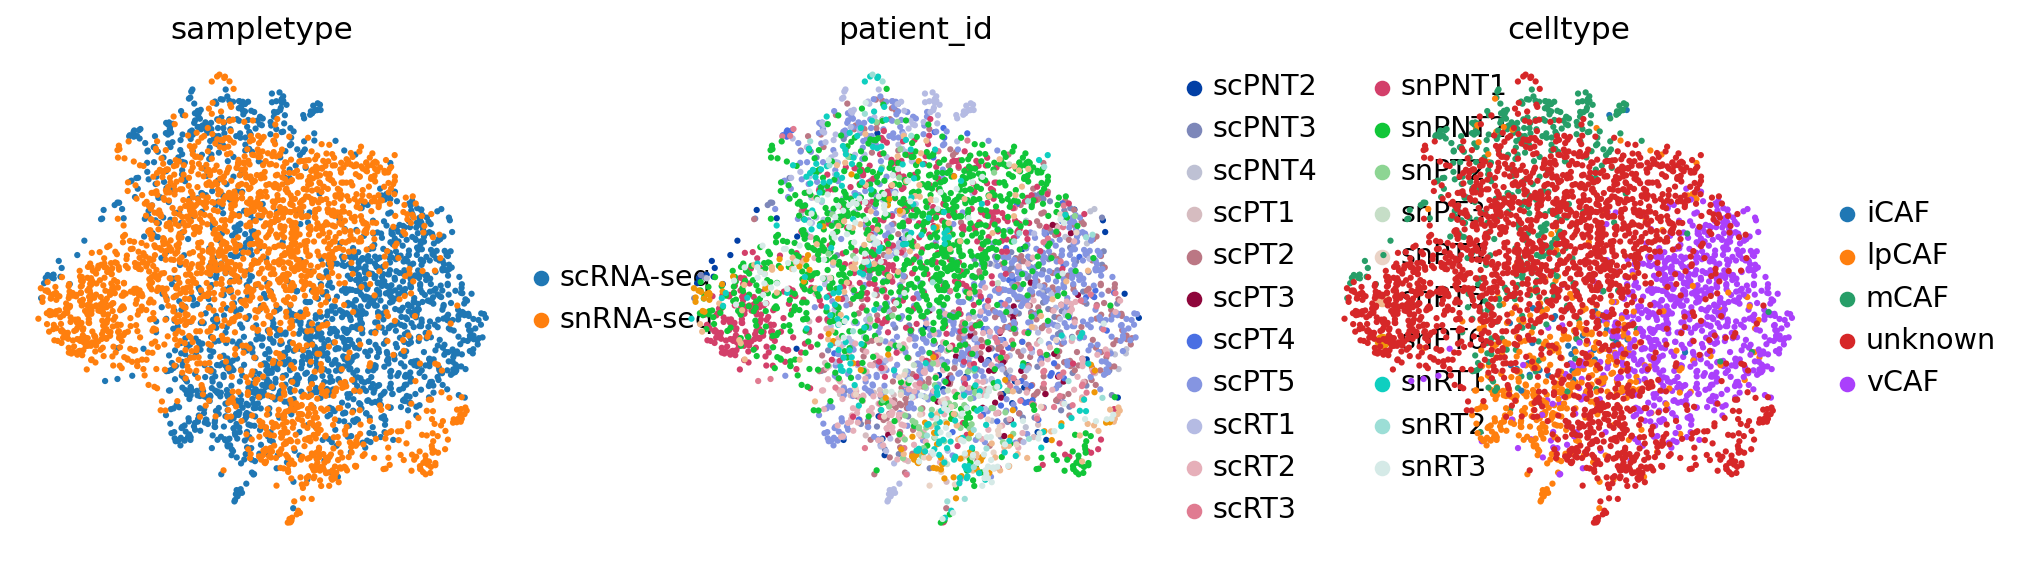

In [18]:
# use the corrected cell embeddings from scvi
sc.pp.neighbors(adata, use_rep='X_scvi')
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["sampletype", "patient_id", "celltype"],
    frameon=False
)

In [19]:
# intergration using scANVI
np.unique(adata.obs["celltype"], return_counts = True)

(array(['iCAF', 'lpCAF', 'mCAF', 'unknown', 'vCAF'], dtype=object),
 array([  36,  421,  420, 2085,  831]))

In [20]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    unlabeled_category="unknown",
    labels_key="celltype",
)

In [21]:
lvae.train(max_epochs=25)

INFO     Training for 25 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25/25: 100%|███████████████████████████████████████████████████| 25/25 [00:12<00:00,  2.06it/s, loss=953, v_num=1]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|███████████████████████████████████████████████████| 25/25 [00:12<00:00,  1.99it/s, loss=953, v_num=1]


In [22]:
# predict labels in snRNA-seq, and get the latent space
adata.obs["C_scANVI"] = lvae.predict(adata)
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)
adata.layers['scanvi_normalized'] = lvae.get_normalized_expression(library_size=10e4)

In [28]:
# use the corrected cell embeddings from scanvi
# the label prediction from scanvi seem to be raletively goo# 
sc.pp.neighbors(adata, use_rep='X_scANVI')
sc.tl.umap(adata, min_dist=0.5)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [24]:
sc.tl.leiden(adata, resolution=0.8, key_added="scanvi_leiden")

running Leiden clustering
    finished: found 10 clusters and added
    'scanvi_leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


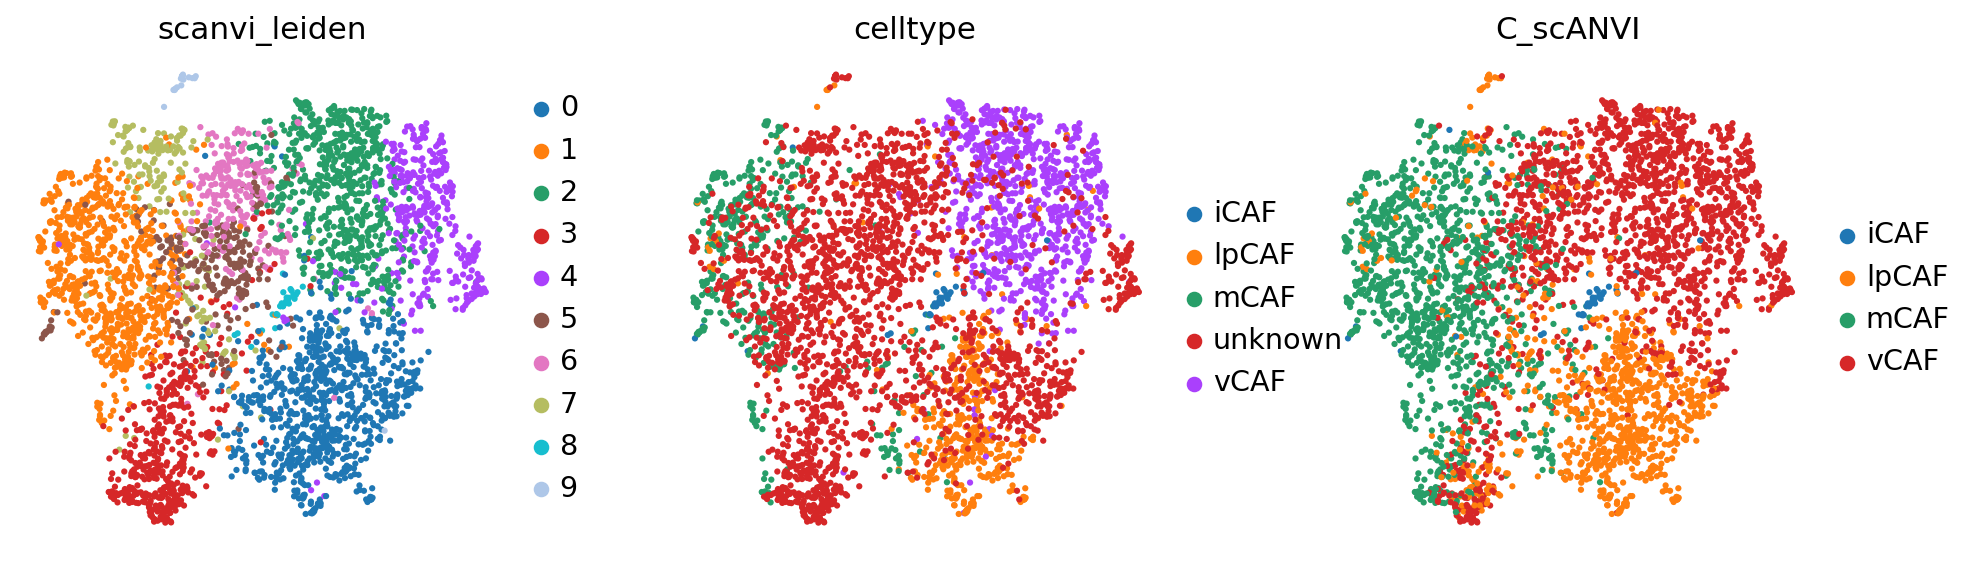

In [37]:
sc.pl.umap(adata, color=['scanvi_leiden', "celltype", "C_scANVI"])

In [24]:
sc.tl.umap(adata, min_dist=0.2)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


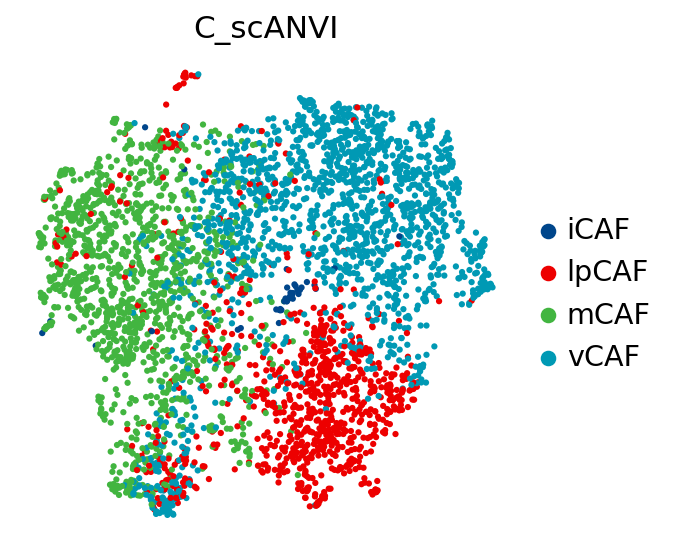

In [50]:
sc.pl.umap(adata, color=["C_scANVI"], palette=["#00468B", "#ED0000", "#42B540", "#0099B4"], save="caf_landscape.pdf")

/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


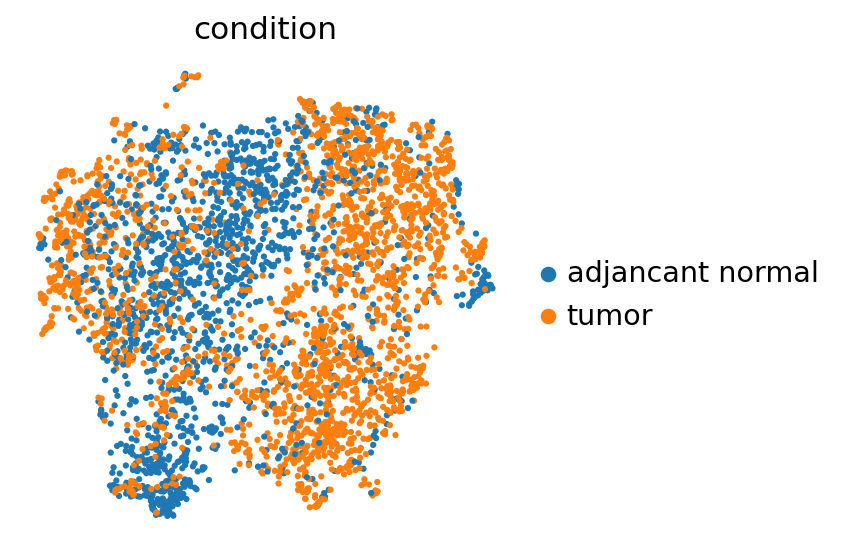

In [47]:
sc.pl.umap(adata, color=["condition"])

In [51]:
adata.write("adata_caf_integ.h5ad")

In [3]:
adata = sc.read_h5ad("adata_caf_integ.h5ad")

In [5]:
# find markers for each cluster
adata.uns['log1p']['base'] = None # solve the key error
sc.tl.rank_genes_groups(adata, 'scanvi_leiden', method='wilcoxon', use_raw=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [6]:
# top 20 genes in each clusters
pd.set_option('display.max_columns', None)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

,0,1,2,3,4,5,6,7,8,9
0,RGS5,COL3A1,JUND,NR1H4,MCAM,KALRN,KALRN,C1S,HSPD1,ADGRL4
1,ADGRF5,VCAN,HSPA1A,LIFR,MYH11,DDAH1,C7,SOD2,EIF5,PLPP1
2,CD36,COL1A2,HSPA1B,ADGRL2,SPARCL1,SAMD4A,PDGFRA,CFH,OAZ1,PRKCH
3,EBF1,COL1A1,C11orf96,ANK3,ACTA2,SERPINE1,CDH19,LPAR1,FKBP4,PPFIBP1
4,NOTCH3,LUM,CRIP1,HGF,ADIRF,EXT1,CRISPLD2,VMP1,TPT1,PTPRB
5,GJC1,THBS2,DNAJB1,IGFBP3,DSTN,SORBS1,MACF1,DPYSL3,HSPE1,ST6GALNAC3
6,CPE,COL5A1,HSP90AA1,ITGA9,TPM2,COL4A1,PDE4D,CLSTN3,SLC3A2,FYN
7,PLXDC1,LTBP2,NR4A1,CCBE1,CRIP1,COL4A2,SVEP1,BICC1,HSPA8,ABLIM1
8,EBF2,DCN,HSPB1,ANKS1A,MYL9,MACF1,ADAMTS2,C7,TCP1,SORBS2
9,MAP1B,CCDC80,HSP90AB1,MASP1,MEF2C,MYOF,ADGRB3,THBS1,CACYBP,ITGA6


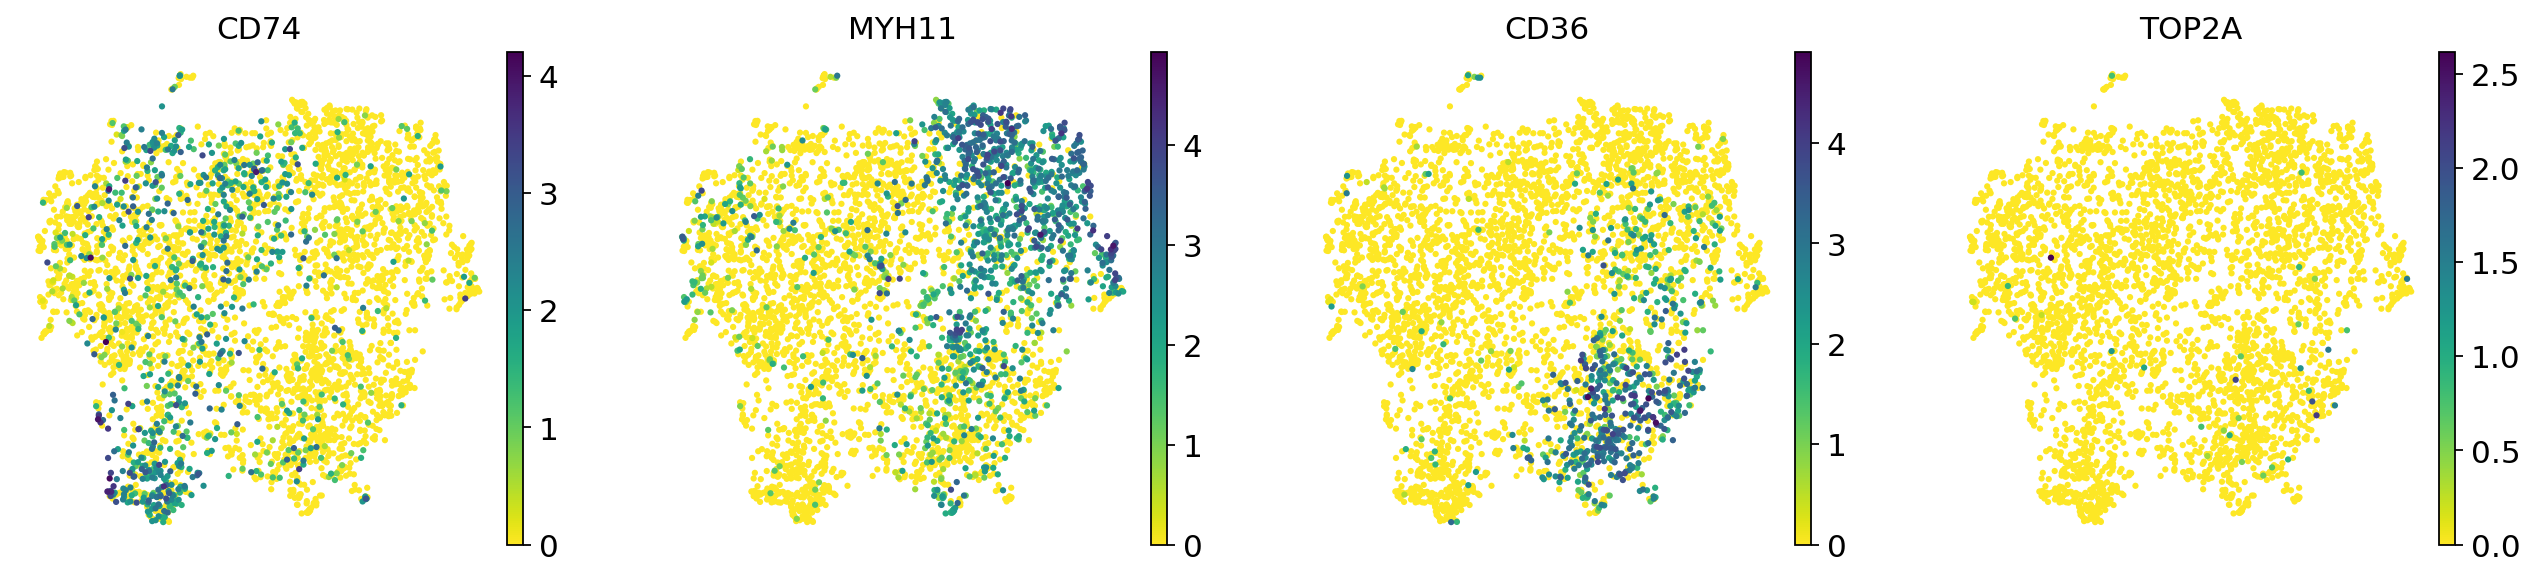

In [4]:
sc.pl.umap(adata, color=["CD74", "MYH11", "CD36", "TOP2A"])

In [7]:
adata = adata[~adata.obs.scanvi_leiden.isin(["9"])]

In [5]:
# re-annotation
adata.obs['celltype_scanvi'] = (
    adata.obs["scanvi_leiden"]
    .map(lambda x: {"0": "lpCAF", "1": "mCAF", "2": "vCAF", "3": "apCAF", "4": "vCAF", "5": "mCAF", "6": "mCAF", "7": "mCAF", "8": "vCAF"}.get(x, x))
    .astype("category")
)

/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


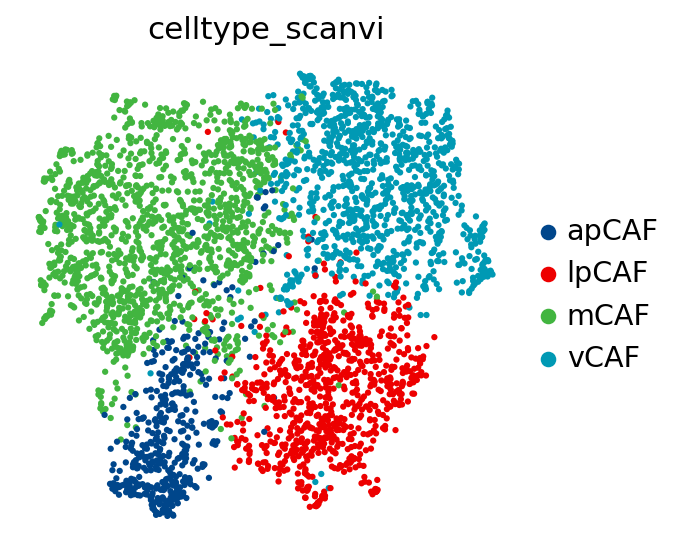

In [8]:
sc.pl.umap(adata, color=["celltype_scanvi"], palette=["#00468B", "#ED0000", "#42B540", "#0099B4"])

In [9]:
adata.write("adata_caf_integ.h5ad")

In [3]:
adata = sc.read_h5ad("adata_caf_integ.h5ad")

In [22]:
markers = {"apCAF": ["CD74", "CCL5"],
                      "lpCAF": ["CD36", "CPM"],
           "mCAF": ["LUM", "VCAN"], 
                      "vCAF": ["MYH11", "MCAM"] }

/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


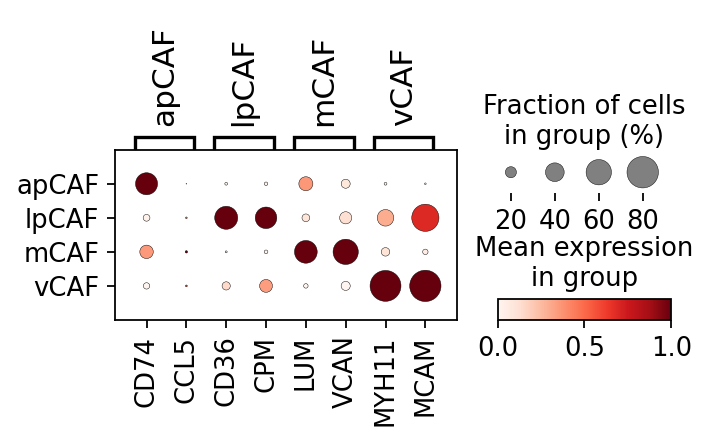

In [23]:
sc.pl.dotplot(adata, markers, "celltype_scanvi", color_map = "Reds", use_raw=True, standard_scale = "var")

In [18]:
adata_raw = adata_sc.concatenate(adata_sn)

/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [19]:
adata

AnnData object with n_obs × n_vars = 3773 × 2000
    obs: 'patient_id', 'condition', 'sampletype', 'nCount_RNA', 'nFeature_RNA', 'mt_ratio', 'celltype', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'scanvi_leiden', 'celltype_scanvi'
    var: 'vst.mean-0', 'vst.variance-0', 'vst.variance.expected-0', 'vst.variance.standardized-0', 'vst.variable-0', 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.variable-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'condition_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'patient_id_colors', 'sampletype_colors', 'scanvi_leiden_colors', 'umap', 'celltype_scanvi_colors'
    obsm: 'X_harmony', 'X_pca', 'X_scANVI', 'X_scanvi', 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scanvi_normalized', 'sc

In [20]:
adata_raw = adata_raw[adata_raw.obs.index.isin(adata.obs.index)]

In [28]:
adata_raw.obs = adata.obs.copy()

In [29]:
adata_raw

AnnData object with n_obs × n_vars = 3773 × 16294
    obs: 'patient_id', 'condition', 'sampletype', 'nCount_RNA', 'nFeature_RNA', 'mt_ratio', 'celltype', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'scanvi_leiden', 'celltype_scanvi'
    var: 'vst.mean-0', 'vst.variance-0', 'vst.variance.expected-0', 'vst.variance.standardized-0', 'vst.variable-0', 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.variable-1'
    obsm: 'X_harmony', 'X_pca', 'X_scanvi', 'X_scvi', 'X_umap'

In [30]:
adata_raw.write("caf_integ_raw.h5ad")